# Example 3 - Quantum Monte Carlo

The study of quantum statistics in polariton condensates is pivotal as it delves into the quantum features of light-matter systems, revealing the transition from incoherent thermal states to coherent states, which is essential for advancing quantum protocols and technologies.

The Monte Carlo approach is instrumental in simulating the dynamics of polariton condensates, providing a robust framework to analyze phase and intensity fluctuations, and thereby quantifying the quantum coherence present within these complex systems.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import time
from collections import defaultdict
from scipy.special import iv as besselfunction
from subprocess import Popen, PIPE

# Path to the PHOENIX executable
PHOENIX_PATH = "../../phoenix_gpu.exe"

# PHOENIX loads local resources, so we need to set the working directory to the location of the executable
PHOENIX_CWD = os.path.dirname( os.path.realpath(PHOENIX_PATH) )

# Path to the data folder relative to PHOENIX_CWD
DATA_PATH = "examples/example_3/data/"

# Create results and load folders
result_path = os.path.join(PHOENIX_CWD, DATA_PATH, "results_neu")

# Create Target Directories
os.makedirs(result_path, exist_ok=True)

# System Parameters
grid_size = 256                  # Grid Size, int this case 200x200
x_max = 230.4                    # mum; Maximum Distance in one direction, meaning the grid will be from -10mum to 10mum
effective_mass = 5.6856E-4       # kg; Effective Mass of the electron, scaled
gamma_c = 0.2                    # Polariton Loss Rate
gamma_r = 1.5 * gamma_c          # Reservoir Loss Rate
R = 0.015                        # Condensation Rate
g_c = 6E-6                       # Polariton-Polariton Coupling
g_r = 2*g_c                      # Polariton-Reservoir Coupling
t_step = 0.04                    # ps; Time step of the simulation

# Special Parameters for this example
pump_amp_factor = gamma_c*gamma_r/R   # Pump Amplitude
pump_sigma = 65/np.sqrt(2)          # Pump Sigma
pump_power = 2                        # Pump Power

# Additional Parameters not required by PHOENIX:
hbar = 6.582119569E-4
dx = 2*x_max/grid_size

# Matrix Generation

In this example, we are fine with using PHOENIX's ability to generate spacial shapes via its envelope syntax.


# Execute Pulse

We create a function to generate the PHOENIX compatible commandline runstring and execute a test calculation.

We also plot the test calculation. The density for the given set of parameters should approach zero.

Because we want a statistical evaluation incorporating noise in every timestep, we use `--dw 1` to enable noise at a scale of 1.

In [ ]:
# Runstring generator
def generate_runstring( *, t_max: float, output_suffix: str = "", pump_amp: float = 2 ):
    # Generate Load Path relative to PHOENIX_CWD
    relative_result_path = os.path.relpath(result_path, PHOENIX_CWD).replace("\\", "/")
    # Append output suffix
    relative_result_path = os.path.join(relative_result_path, output_suffix)
    # Build runstring
    runstring = f"{PHOENIX_PATH} "
    runstring += f"--path {relative_result_path} "      # Set the output path
    runstring += f"--N {grid_size} {grid_size} "        # Set the grid size in points
    runstring += f"--L {x_max} {x_max} "                # Set the grid size in mum
    runstring += f"--meff {effective_mass} "            # Set the effective mass
    runstring += f"--hbarscaled {hbar} "                # Set the scaled reduced Planck constant
    runstring += f"--tmax {t_max} "                     # Set the end time
    runstring += f"--tstep {t_step} "                   # Set the time step
    runstring += "--outEvery 250 "                      # Set sample rate to 250ps. We dont need intermediate results, so setting this high will increase the simulation speed
    runstring += f"--gc {g_c} "                         # Set the coupling constants
    runstring += f"--gr {g_r} "                         # Set the coupling constants
    runstring += f"--R {R} "                            # Set the condensation rate
    runstring += f"--gammaR {gamma_r} "                 # Set the reservoir loss rate
    runstring += f"--gammaC {gamma_c} "                 # Set the polariton loss rate
    runstring += "-nosfml "                             # Disable SFML output
    runstring += "--fftEvery 5 "                        # Set the FFT sample rate. Even though we dont need the FFT, setting this high will increase the simulation speed as the FFT is still calculated.
    runstring += "--initRandom 1E-7 random "            # Randomly initialize the wavefunction since we dont load an initial wavefunction
    runstring += "--boundary periodic periodic "        # Set periodic boundary conditions in both directions
    runstring += "--output wavefunction "               # Output only the wavefunction
    runstring += "--threads 2 "                         # Use 2 CPU Threads
    # Add a pump pulse
    runstring += f"--pump {pump_amp*pump_amp_factor} add {pump_sigma} {pump_sigma} 0 0 plus {pump_power} none gauss+noDivide " 
    # Add Quantum Noise with scaling Amplitude of 1
    runstring += f"--dw 1"
    return runstring

In [ ]:
# Test Calculation, Execute PHOENIX
runstring = generate_runstring( t_max = 2000 )
# Call the runstring and wait for the subprocess to finish
process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PHOENIX_CWD )
stdout, stderr = process.communicate()
# Print the output
print(stdout.decode("utf-8"))

---------------------------- Inputting System Parameters --------------------------
[ ⚠ ] Overwritten (initial) dt to 0.040000
[ ℹ ] Halo Size for iterator 'rk4' = 4
[ ℹ ] Parsing envelope 'pump'
[ ✓ ] Added Spacial Component to Envelope 'pump'
[ ℹ ] Using Reservoir: 1
[ ℹ ] Using Pumps: 1
[ ℹ ] Using Pulses: 0
[ ℹ ] Using Potentials: 0
[ ℹ ] Using Stochastic: 1
[ ℹ ] Successfully created directory 'examples/example_3/data/results_neu\/'
[ ℹ ] Creating Solver...
-------------------- Initializing Host and Device Matrices ------------------------
[ ℹ ] Initializing Halo Map...
[ ✓ ] Designated number of halo cells: 4160
[ ℹ ] Initializing Host Matrices...
[ ℹ ] Initializing Pump Envelopes...
[ ✓ ] Succesfull, designated number of pump groups: 1
[ ℹ ] Initializing Potential Envelopes...
[ ✓ ] Succesfull, designated number of potential groups: 0
[ ℹ ] Initializing Pulse Envelopes...
[ ✓ ] Succesfull, designated number of pulse groups: 0
[ ℹ ] Initializing FFT Envelopes...
[ ⚠ ] No fft mask

### Plotting
PHOENIX saves outputs using one row per line, saving real parts first. This means, for our NxN complex matrices, PHOENIX will output a textfile containing a 2NxN (rows,cols) matrix. When loading the real and imaginary parts of the result, we can also calculate the phase using `np.angle`. Since we did not precalculate any of the matrices, we also do not have and X,Y matrix at this point in time. We could generate an X,Y meshgrid here, but we can also simply plot the matrix without any bounds.

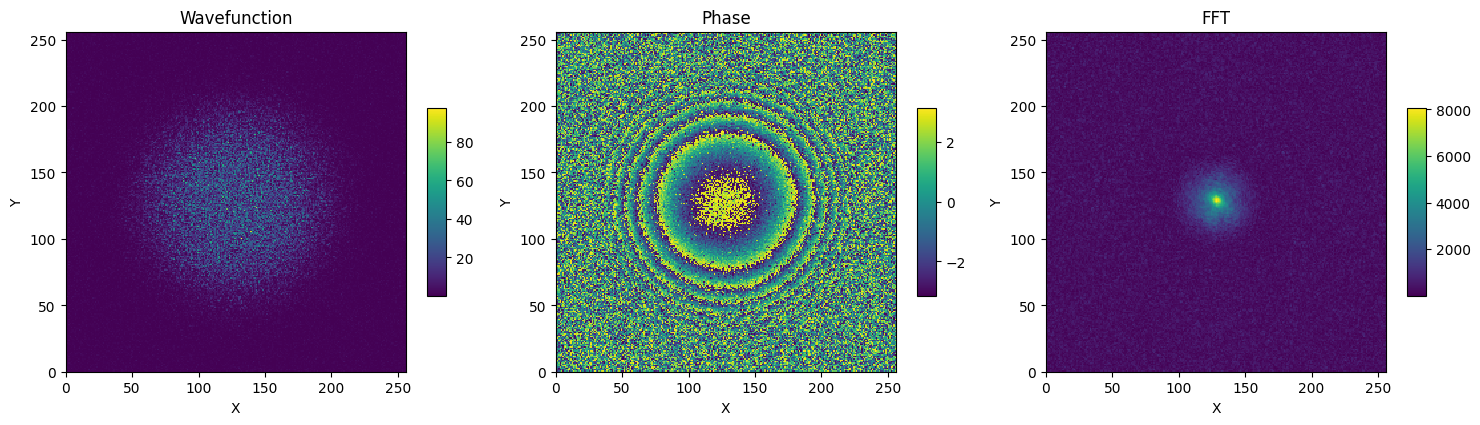

In [7]:
# Plot Results
data = np.loadtxt( os.path.join(result_path, "wavefunction_plus.txt") )
re,im = data[:grid_size,:], data[grid_size:,:]
psi = (re + 1j*im).reshape(grid_size,grid_size)
fft = np.fft.fftshift( np.fft.fft2(psi) )

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_title("Wavefunction")
plt_psi = ax1.pcolormesh(np.abs(psi)**2)
ax2.set_title("Phase")
plt_phase = ax2.pcolormesh(np.angle(psi))
ax3.set_title("FFT")
plt_fft = ax3.pcolormesh(np.abs(fft))

for ax,plot in zip((ax1,ax2,ax3),(plt_psi,plt_phase,plt_fft)):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)

plt.tight_layout()

In [ ]:
monte_carlo_sims = 10
t_max = 2000  # ps; Maximum time for the simulation
pump_amps = [3,4,5,6,7]


for amp in pump_amps:
    # Calculate unique suffix for this batch of simulations. In this case, we use the current time
    output_suffix = f"monte_carlo_{t_max}_{amp}_{int(time.time())}"

    for i in range(monte_carlo_sims):
        current_output_suffix = f"{output_suffix}_{i}"
        runstring = generate_runstring( t_max = t_max, output_suffix = current_output_suffix, pump_amp = amp )
        # Call the runstring and wait for the subprocess to finish
        process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PHOENIX_CWD )
        process.communicate()
        print(f"Simulation {amp} - {i+1}/{monte_carlo_sims} finished")

Simulation 3 - 1/10 finished
Simulation 3 - 2/10 finished
Simulation 3 - 3/10 finished
Simulation 3 - 4/10 finished
Simulation 3 - 5/10 finished
Simulation 3 - 6/10 finished
Simulation 3 - 7/10 finished
Simulation 3 - 8/10 finished
Simulation 3 - 9/10 finished
Simulation 3 - 10/10 finished
Simulation 4 - 1/10 finished
Simulation 4 - 2/10 finished
Simulation 4 - 3/10 finished
Simulation 4 - 4/10 finished
Simulation 4 - 5/10 finished
Simulation 4 - 6/10 finished
Simulation 4 - 7/10 finished
Simulation 4 - 8/10 finished
Simulation 4 - 9/10 finished
Simulation 4 - 10/10 finished
Simulation 5 - 1/10 finished
Simulation 5 - 2/10 finished
Simulation 5 - 3/10 finished
Simulation 5 - 4/10 finished
Simulation 5 - 5/10 finished
Simulation 5 - 6/10 finished
Simulation 5 - 7/10 finished
Simulation 5 - 8/10 finished
Simulation 5 - 9/10 finished
Simulation 5 - 10/10 finished
Simulation 6 - 1/10 finished
Simulation 6 - 2/10 finished
Simulation 6 - 3/10 finished
Simulation 6 - 4/10 finished
Simulation 

In [19]:
# We will save the b values in a cache for later use
b_cache = defaultdict(list)

# We apply a simple filter to only load the results of the simulations which satisfy certain conditions
filter = lambda x: f"_{t_max}_" in x

for monte_carlo_sim in [folder for folder in os.listdir(result_path) if os.path.isdir(os.path.join(result_path, folder)) and filter(folder)]:
    # Get used Amp
    amp = float(monte_carlo_sim.split("_")[-3])
    # Load the Wavefunction and calculate the resulting FFT
    data = np.loadtxt( os.path.join(result_path, monte_carlo_sim, "wavefunction_plus.txt") )
    re,im = data[:grid_size,:], data[grid_size:,:]
    psi = (re + 1j*im).reshape(grid_size,grid_size)
    fft = np.fft.fftshift( np.fft.fft2(psi) )

    # Center of fft is at grid_size/2
    center = grid_size//2 + 1
    b = fft[center,center]
    b_cache[amp].append(b)

# Rescale and turn into numpy array
b_cache = {key : np.array(val) * dx*dx/(2*x_max) for key,val in b_cache.items()}

We can Plot the b cache to see the statistical variance

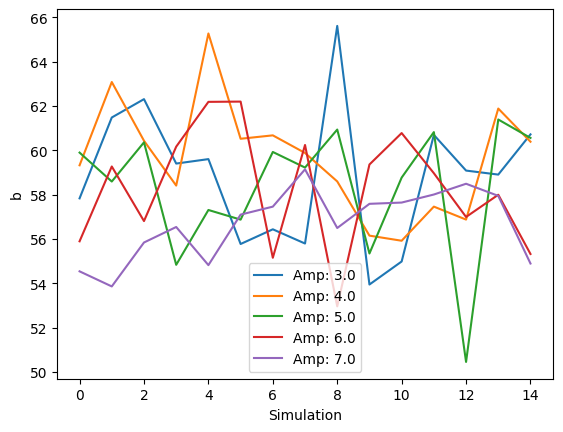

In [20]:
fig, ax = plt.subplots()
for key in b_cache:
    ax.plot( np.abs(b_cache[key]), "-", label=f"Amp: {key}")
ax.set_xlabel("Simulation")
ax.set_ylabel("b")
ax.legend()

# Calculate the Quantum Correlations

In [ ]:
correlations = []

for amp, current in b_cache.items():
    
    simulations = len(current)

    # Expectation
    n_c = np.sum( np.abs(current)**2 )/simulations

    # Variance
    delta_nc = np.sum( np.abs(current)**4 )/simulations - np.sum( np.abs(current)**2 ) / simulations - n_c**2

    # Calculate C according to https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.2.030320
    alpha02 = np.sqrt( -delta_nc + n_c + n_c**2 )
    nbar = n_c - alpha02
    factor = (2*alpha02/((nbar+1)**2 - nbar**2))
    I = besselfunction(0, factor)
    C = ( 1 - np.exp( -( 2*alpha02 / ( ( nbar + 1 )**2 - nbar**2 ) ) ) * I ) / ( ( nbar + 1 )**2 - nbar**2 ) 

    #print(f"Amp: {amp}")
    #print(f"Quantum Correlation\n    {I = }\n    {factor = }\n    {nbar = }\n    {alpha02 = }\n    {n_c = }\n    {delta_nc = }")
    #print(f"C = {C}")
    correlations.append(C)

C:\Users\David Bauch\AppData\Local\Temp\ipykernel_17004\1482208137.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  C = ( 1 - np.exp( -( 2*alpha02 / ( ( nbar + 1 )**2 - nbar**2 ) ) ) * I ) / ( ( nbar + 1 )**2 - nbar**2 )


[np.float64(190.91132035431318), np.float64(293.9956325347919), np.float64(227.7354850937194), np.float64(259.13088246306415), np.float64(775.9163201168785)]


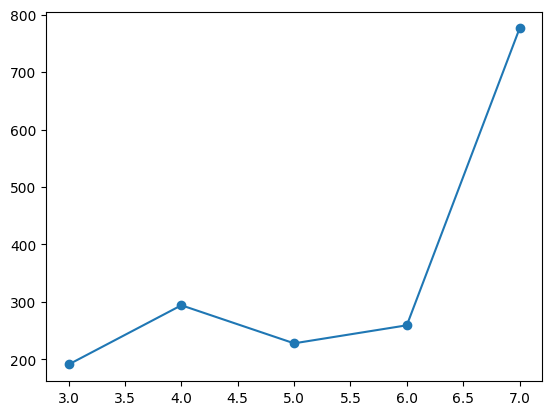

In [23]:
print(correlations)
plt.plot(pump_amps, correlations, "o-")